**Progetto Text Mining** <br>
Reviews classification

In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
import gzip
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import to_categorical
from matplotlib import pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
drive.mount('/content/gdrive') #login

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Sono state definite due funzioni che consentono di importare i dati delle recensioni di amazon.

In [0]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

Utilizzando la funzione "getDF" sono stati importati gli 11 dataset contenenti le reviews delle 11 categorie utilizzate.

In [0]:
path = 'gdrive/My Drive/TextMining/Dataset/'

df_food = getDF(path + 'reviews_Grocery_and_Gourmet_Food_5.json.gz')
df_auto = getDF(path + 'reviews_Automotive_5.json.gz')
df_beauty = getDF(path + 'reviews_Beauty_5.json.gz')
df_phones = getDF(path + 'reviews_Cell_Phones_and_Accessories_5.json.gz')
df_music = getDF(path + 'reviews_Digital_Music_5.json.gz')
df_office = getDF(path + 'reviews_Office_Products_5.json.gz')
df_garden = getDF(path + 'reviews_Patio_Lawn_and_Garden_5.json.gz')
df_pet = getDF(path + 'reviews_Pet_Supplies_5.json.gz')
df_home = getDF(path + 'reviews_Tools_and_Home_Improvement_5.json.gz')
df_toys = getDF(path + 'reviews_Toys_and_Games_5.json.gz')
df_vgames = getDF(path + 'reviews_Video_Games_5.json.gz')

Di seguito è riportato il numero di reviews per ogni categoria.

In [0]:
tot_df = [df_food, df_auto, df_beauty, df_phones, df_music, df_office, df_garden, df_pet, df_home, df_toys, df_vgames]
for el in tot_df:
    print(len(el))

151254
20473
198502
194439
64706
53258
13272
157836
134476
167597
231780


Gli 11 dataset sono stati concatenati in un unico dataframe con 1387593 osservazioni. Inoltre, è stata aggiunta la variabile "y" che indica la categoria di appartenenza (con un indice che va da 0 a 10).

In [0]:
i = 0
for el in tot_df:
    el['y'] = i
    i += 1
df = pd.concat(tot_df)
n_labels = i
len(df)

1387593

Le colonne di interesse per l'analisi sono "reviewText" e "y".

In [0]:
df.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'y'],
      dtype='object')

È stato dunque salvato il subsetting del dataset con solo le due colonne di interesse in una nuova variabile.

In [0]:
my_data = df[['reviewText','y']]
my_data['reviewText'].head()

0    Just another flavor of Kit Kat but the taste i...
1    I bought this on impulse and it comes from Jap...
2    Really good. Great gift for any fan of green t...
3    I had never had it before, was curious to see ...
4    I've been looking forward to trying these afte...
Name: reviewText, dtype: object

**Preprocessing del testo** <br>
Nella prima fase di preprocessing tutto il testo è stato reso minuscolo.

In [0]:
my_data['reviewText'] = my_data['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
my_data['reviewText'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    just another flavor of kit kat but the taste i...
1    i bought this on impulse and it comes from jap...
2    really good. great gift for any fan of green t...
3    i had never had it before, was curious to see ...
4    i've been looking forward to trying these afte...
Name: reviewText, dtype: object

Successivamente, è stata rimossa la punteggiatura.

In [0]:
my_data['reviewText'] = my_data['reviewText'].str.replace('[^\w\s]','')
my_data['reviewText'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    just another flavor of kit kat but the taste i...
1    i bought this on impulse and it comes from jap...
2    really good great gift for any fan of green te...
3    i had never had it before was curious to see w...
4    ive been looking forward to trying these after...
Name: reviewText, dtype: object

Sono state inoltre rimosse le stop words tramite il libreria "nltk" che mette a disposizione un dizionario di stopwords inglesi.

In [0]:
stop = stopwords.words('english')
my_data['reviewText'] = my_data['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
my_data['reviewText'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    another flavor kit kat taste unique bit differ...
1    bought impulse comes japan amused family weird...
2    really good great gift fan green tea expensive...
3    never curious see like smooth great subtle goo...
4    ive looking forward trying hearing popular jap...
Name: reviewText, dtype: object

Un'altra fase importante della pipeline di preprocessing è la lemmatization, tecnica utilizzata per riportare semanticamente al lemma le parole presenti nel testo. È stata preferita la lemmatization allo stemming in quanto con il modulo python che la implementa sono stati ottenuti buoni risultati in tempi computazionali ragionevoli, mentre con l'algoritmo di Porter per lo stemming i tempi computazionali erano troppo lunghi. Inoltre, la lemmatization garantisce una distinzione semantica tra termini con la stessa radice, ma utilizzati in contesti diversi. Anche per questo motivo risulta essere una tecnica opportuna per il task di classificazione in esame.



In [0]:
my_data['reviewText'] = my_data['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
my_data['reviewText'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


0    another flavor kit kat taste unique bit differ...
1    bought impulse come japan amused family weird ...
2    really good great gift fan green tea expensive...
3    never curious see like smooth great subtle goo...
4    ive looking forward trying hearing popular jap...
Name: reviewText, dtype: object

È stata infine costruita una matrice avente numero di righe pari al numero di osservazioni e 10000 colonne. Il peso associato ad ogni cella è la tf-idf del termine (colonna) per una determinate recensione (riga). Ovviamente ci sarebbero più di 10000 termini da considerare, ma per ridurre la sparsità, con la funzione TfidfVectorizer del pacchetto "sklearn", è stato deciso di tenere solo 10000 features (i termini più significativi).

In [0]:
tfidf = TfidfVectorizer(max_features=10000, analyzer='word',ngram_range=(1,1))
train_vect = tfidf.fit_transform(my_data['reviewText'])

Il risultato di questa operazione è una matrice sparsa con 1387593 righe e 10000 colonne.

In [0]:
train_vect

<1387593x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 60263283 stored elements in Compressed Sparse Row format>

Per comodità, la colonna "y" del dataframe "my_data" è stata salvata in una variabile.

In [0]:
y = my_data.y

Dal momento che il procedimento fino a qui svolto risulta essere abbastanza oneroso dal punto di vista computazionale, è stato fatto un dump della matrice sparsa e delle labels tramite la libreria joblib.

In [0]:
joblib.dump([train_vect, y], 'feat_data.joblib')
#my_dump = joblib.load('feat_data.joblib')
#train_vect = my_dump[0]
#y = my_dump[1]

['feat_data.joblib']

**Classification** <br>
Il dataset è stato diviso in training set e test set. Nel test set saranno presenti il 10% delle osservazioni totali. Tale percentuale risulta essere adeguata dato il numero elevato di osservazioni totali.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_vect, y, test_size=0.1, random_state=1)

In [0]:
len(y_test)

138760

È stata dunque utilizzato come classificatore una rete neurale fully connected con 4 strati nascosti (con rispettivamente 2048 - 2048 - 1024 - 512 neuroni). Come funzione di attivazione per i neuroni degli strati nascosti viene utilizzata la "relu", mentre lo strato di output ha 11 neuroni a cui viene applicata la funzioni di attivazione softmax. In questo modo la rete ci fornirà in output la probabilità di appartenenza alle classi.

In [0]:
model = Sequential([
    Dense(2048, input_dim=10000),
    Activation('relu'),
    Dense(2048),
    Activation('relu'),
    Dense(1024),
    Activation('relu'),
    Dense(512),
    Activation('relu'),
    Dense(n_labels),
    Activation('softmax'),
])

Come ottimizzatore è stato utilizzato "adam" con parametri di default e come funzione di perdita è stata scelta la "categorical crossentropy". È stata anche dichiarata come metrica da valutare l'accuracy.

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

È necessario infine utilizzare la "one hot encode" come codifica della variabile risposta.

In [0]:
one_hot_labels = to_categorical(y_train, num_classes=n_labels)

Nella fase di training del modello vengono utilizzate 3 epoche e batch size pari a 1024. Sebbene come batch size è abbastanza grande, il numero di osservazioni presenti nel training set ci consente comunque di ottenere ottime prestazioni. Inoltre, con una batch size elevata, il tempo di computazione si riduce notevolmente. Da notare infine che il 20% dei dati di training viene utilizzato come validation set, su cui verranno valutate accuracy e loss function alla fine di ogni epoca.

In [0]:
model.fit(X_train, one_hot_labels, epochs=3, batch_size=1024, validation_split=0.2)

Train on 999066 samples, validate on 249767 samples
Epoch 1/3
999066/999066 [==============================] - 152s 153us/step - loss: 0.2786 - acc: 0.9134 - val_loss: 0.2198 - val_acc: 0.9302
Epoch 2/3
999066/999066 [==============================] - 151s 151us/step - loss: 0.1490 - acc: 0.9529 - val_loss: 0.2092 - val_acc: 0.9352
Epoch 3/3
999066/999066 [==============================] - 151s 151us/step - loss: 0.0576 - acc: 0.9817 - val_loss: 0.2587 - val_acc: 0.9322


Viene raggiunta una accuracy di 0.9817 sul training set e di 0.9322 sul validation set. <br>
La rete trainata è stata quindi utilizzata per predirre i dati di test.

In [0]:
y_preds = model.predict(X_test)

Visto che il modello mi restituisce la probabilità di appartenenza alle 11 classi, è stata scelta come classe predetta dal modello quella con probabilità associata maggiore. 

In [0]:
y_preds = [x.argmax() for x in y_preds]

La rappresentazione visuale della confusion matrix tra categoria reale e categoria predetta in fase di test è la seguente.

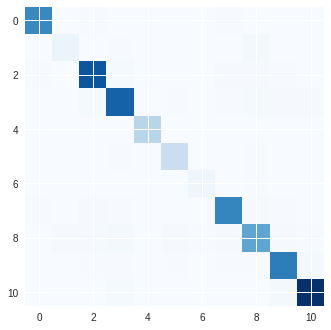

In [0]:
cm = confusion_matrix(y_test, y_preds)
plt.imshow(cm, cmap='Blues')

Si ottiene dunque la seguente accuracy.

In [0]:
accuracy_score(y_test, y_preds)

0.9314067454597866

Anche se si può notare un leggero overfitting, i risultati ottenuti in fase di test sono comunque buoni. <br>
Il report di classificazione in cui vengono riportati precision, recall e f1-score è il seguente.

In [0]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     15100
           1       0.79      0.66      0.72      2068
           2       0.94      0.94      0.94     19965
           3       0.93      0.93      0.93     19216
           4       0.98      0.98      0.98      6535
           5       0.87      0.92      0.90      5318
           6       0.78      0.78      0.78      1263
           7       0.93      0.94      0.93     15850
           8       0.88      0.87      0.88     13575
           9       0.92      0.93      0.92     16759
          10       0.96      0.96      0.96     23111

   micro avg       0.93      0.93      0.93    138760
   macro avg       0.90      0.90      0.90    138760
weighted avg       0.93      0.93      0.93    138760



Anche considerando questo genere di metriche, i risultati ottenuti sono decisamente buoni.